# Mean Curvature Flow

Mean curvature flow is a specific example of a geometric evolution
equation where the evolution is governed by the mean curvature $H$.
One real-life example of this is in how soap films change over time,
although it can also be applied to image processing (e.g.
<cite data-cite="Malladi"></cite>
Assume we can define a reference surface $\Gamma_0$ such that
we can write the evolving surface $\Gamma(t)$ in the form
\begin{gather*}
\Gamma(t) = X(t,\Gamma_0).
\end{gather*}
It is now possible to show that the vector valued function $X=X(t,x)$
with $x\in\Gamma_0$ satisfies
\begin{gather*}
\frac{\partial}{\partial_t}X = - H(X)\nu(X),
\end{gather*}
where $H$ is the mean curvature of $\Gamma_t$ and $\nu$ is its outward pointing normal.

We will solve this using a finite element approach based on the
following time discrete approximation from
<cite data-cite="Charlie"></cite>
(with a $\theta$-scheme applied).
\begin{align*}
\int_{\Gamma^n} \big( U^{n+1} - {\rm id}\big) \cdot \varphi +
\tau \int_{\Gamma^n} \big(
\theta\nabla_{\Gamma^n} U^{n+1} + (1-\theta) I \big)
\colon\nabla_{\Gamma^n}\varphi
=0.
\end{align*}
Here $U^n$ parametrizes $\Gamma(t^{n+1})$ over
$\Gamma^n:=\Gamma(t^{n})$, $I$ is the identity matrix, $\tau$ is the
time step and $\theta\in[0,1]$ is a discretization parameter.
<img src="mcf.gif" style="height:228px;">

In [1]:
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
import math

from ufl import *
from dune.ufl import Constant, DirichletBC
import dune.ufl
import dune.geometry as geometry
import dune.fem as fem
from dune.fem.plotting import plotPointData as plot
import matplotlib.pyplot as pyplot
from IPython import display

set up polynomial order and radius of reference surface

In [2]:
order = 2
R0 = 2.

We begin by setting up reference domain $\Gamma_0$ (```grid```), and the space on $\Gamma_0$ that describes $\Gamma(t)$ (```space```). From this we interpolate the non-spherical initial surface ```positions```, and, then reconstruct ```space``` for the discrete solution on $\Gamma(t)$.

In [3]:
from dune.fem.view import geometryGridView
from dune.fem.space import lagrange as solutionSpace
from dune.alugrid import aluConformGrid as leafGridView
gridView = leafGridView("sphere.dgf", dimgrid=2, dimworld=3)
space = solutionSpace(gridView, dimRange=gridView.dimWorld, order=order)
u = TrialFunction(space)
v = TestFunction(space)
x = SpatialCoordinate(space)
# positions = space.interpolate(x * (1 + 0.5*sin(2*pi*x[0]*x[1])* cos(pi*x[2])), name="position")
positions = space.interpolate(x * (1 + 0.5*sin(2*pi*(x[0]+x[1]))*cos(0.25*pi*x[2])), name="position")
surface = geometryGridView(positions)
space = solutionSpace(surface, dimRange=surface.dimWorld, order=order)
solution = space.interpolate(x, name="solution")

We set up the theta scheme with $\theta = 0.5$ (Crank-Nicholson).

In [4]:
from dune.fem.scheme import galerkin as solutionScheme
theta = 0.5
I = Identity(3)
dt = Constant(0, "dt")

a = (inner(u - x, v) + dt * inner(theta*grad(u) + (1 - theta)*I, grad(v))) * dx
scheme = solutionScheme(a == 0, space, solver="cg")

Now we solve the scheme in time. We first set up the initial time variables, then we plot the initial figure's mesh, and finally we begin the loop, updating ```positions``` on each step and plotting the results side-by-side.

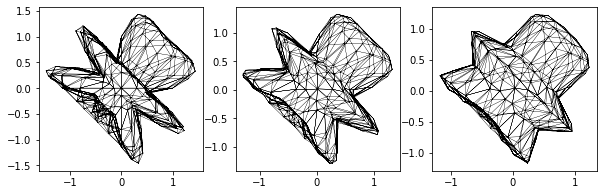

In [5]:
count = 0
t = 0.
end_time = 0.05
scheme.model.dt = 0.005

fig = pyplot.figure(figsize=(10, 10))
plot(solution, figure=(fig, 131+count%3), colorbar=False,
     gridLines="", triplot=True)

while t < end_time:
    scheme.solve(target=solution)
    t += scheme.model.dt
    count += 1
    positions.dofVector.assign(solution.dofVector)
    if count % 4 == 0:
        plot(solution, figure=(fig, 131+count%3), colorbar=False,
             gridLines="", triplot=True)
pyplot.show()
pyplot.close('all')

By chosing an initial surface with boundary we can solve the _soap film_
problem, i.e., compute the surface of minimum curvature:

In [6]:
referenceView = leafGridView("soap.dgf", dimgrid=2, dimworld=3)
referenceView.hierarchicalGrid.globalRefine(8)
space = solutionSpace(referenceView, dimRange=referenceView.dimWorld,
        order=order)

# setup deformed surface
x         = SpatialCoordinate(space)
# npte that 'positions' also deforms the boundary which will then be fixed
# during the evolution by the chosen boundary conditions:
positions = space.interpolate(x * (1 + 0.5*sin(2*pi*(x[0]+x[1]))*cos(0.25*pi*x[2])), name="position")
gridView  = geometryGridView(positions)
space     = solutionSpace(gridView, dimRange=gridView.dimWorld, order=order)

u     = TrialFunction(space)
phi   = TestFunction(space)
dt    = Constant(0.01, "timeStep")
t     = Constant(0.0, "time")
endTime      = 0.4
saveInterval = 0.1

# define storage for discrete solutions
uh     = space.interpolate(x, name="uh")
uh_old = uh.copy()

# problem definition

# space form
xForm = inner(grad(u), grad(phi)) * dx

# add time discretization
form = dot(u - uh_old, phi) * dx + dt * xForm

# define dirichlet boundary conditions - freezing the boundary
bc = DirichletBC(space,x)

# setup scheme
dune.fem.parameter.append({"fem.verboserank": 0})
solverParameters =\
       {"newton.tolerance": 1e-9,
        "newton.linear.tolerance": 1e-11,
        "newton.linear.preconditioning.method": "jacobi"}
scheme = solutionScheme([form == 0, bc], space, solver="cg",
                        parameters=solverParameters)

nextSaveTime = saveInterval
count = 0

So far we can only plot x/y coordinates using matplotlib which does not
give a good impression of the surface (we use it nevertheless for showing
the evolution). To get a 3d view we can use mayavi (and that can even be
interactive within a jupyter notebook):

Notebook initialized with png backend.



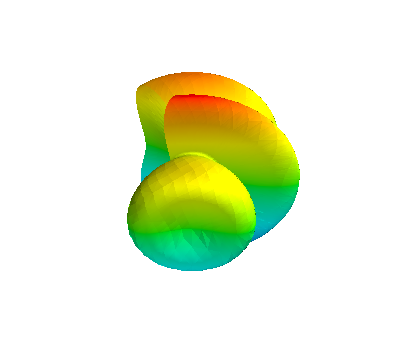

In [7]:
try:
    from mayavi import mlab
    from mayavi.tools.notebook import display
    def plot3d(uh,level):
        x, triangles = uh.space.grid.tesselate(level)
        mlab.init_notebook("png") # use x3d for interactive plotting in the notebook
        mlab.figure(bgcolor = (1,1,1))
        s = mlab.triangular_mesh(x[:,0],x[:,1],x[:,2],triangles)
        display( s )
except ImportError:
    def plot3d(uh,level):
        pass

plot3d(uh,2)

Now the time loop

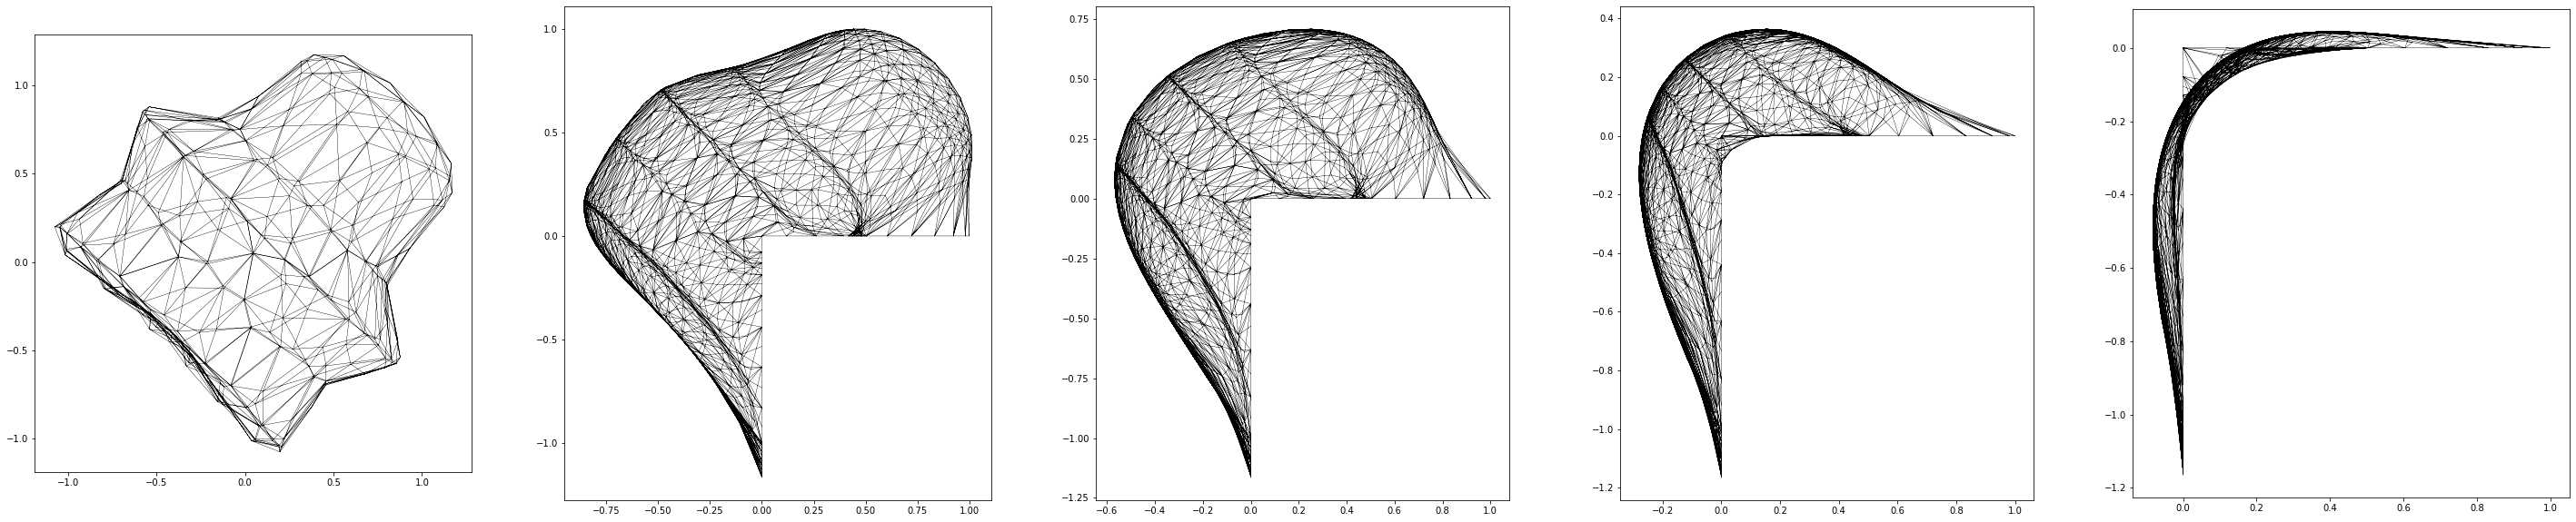

Notebook initialized with png backend.



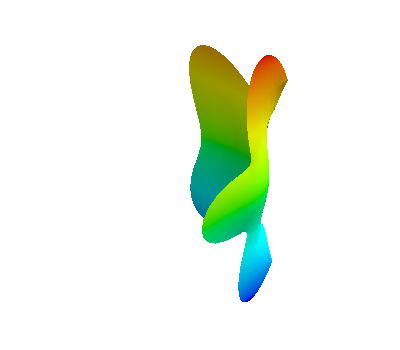

In [8]:
fig = pyplot.figure(figsize=(50, 10))
plot(solution, figure=(fig, 151+count), colorbar=False,
     gridLines="", triplot=True)
while t.value < endTime:
    uh_old.assign(uh)
    info = scheme.solve(target=uh)
    t.value += dt.value

    positions.dofVector.assign(uh.dofVector)

    if t.value >= nextSaveTime or t.value >= endTime:
        nextSaveTime += saveInterval
        count += 1
        plot(uh, figure=(fig, 151+count), colorbar=False,
             gridLines="", triplot=True)
pyplot.show()
pyplot.close('all')

plot3d(uh,2)